In [1]:
import pandas as pd
import numpy as np 
import os 
import matplotlib.pyplot as plt
import shutil
import ast


Preprocessing
===

In [2]:
directory_path = r".\data\AA_CCLE_hg38_aggregated_050323\AA_CCLE_hg38_aggregated_050323\AA_outputs"
output_path = r".\data\AA_CCLE_hg38_aggregated_050323/BREAST"
def move_bed_files(directory_path, output_path, cancertype):
    os.makedirs(output_path, exist_ok=True)
    for directory in os.listdir(directory_path):
        if cancertype in directory:
            sample_path = os.path.join(directory_path, directory)
            for sample in os.listdir(sample_path):
                if ".bed" in sample:
                    shutil.copy(os.path.join(sample_path, sample), os.path.join(output_path, sample))
move_bed_files(directory_path, output_path, "BREAST")                   

In [3]:
# obtain the different types:
locations = pd.DataFrame()
for file in os.listdir(output_path):
    try:
        temp = pd.read_csv(os.path.join(output_path, file), sep = "\t", names = ['chromosome', 'start', 'end', 'stat', 'cycle_file'])
        locations = pd.concat([locations, temp])
    except Exception as e:
        print(e)
locations.head(2)

C:\Users\albao\AppData\Local\Temp\ipykernel_6120\3935881428.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  locations = pd.concat([locations, temp])
C:\Users\albao\AppData\Local\Temp\ipykernel_6120\3935881428.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  locations = pd.concat([locations, temp])
C:\Users\albao\AppData\Local\Temp\ipykernel_6120\3935881428.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this wil

,chromosome,start,end,stat,cycle_file
0,chr3,37936027,38301037,4.696643,/expanse/lustre/projects/csd714/edwin5588/CCLE...
1,chr7,114216157,115016148,7.312990,/expanse/lustre/projects/csd714/edwin5588/CCLE...


In [4]:
locations = pd.read_csv("./data/AA_CCLE_hg38_aggregated_050323/BREAST.csv", names = ['chromosome', 'start', 'end', 'stat', 'cycle_file'])
locations

,chromosome,start,end,stat,cycle_file
0,chr3,37936027,38301037,4.696643,/expanse/lustre/projects/csd714/edwin5588/CCLE...
1,chr7,114216157,115016148,7.312990,/expanse/lustre/projects/csd714/edwin5588/CCLE...
2,chr7,125406023,128940980,8.379136,/expanse/lustre/projects/csd714/edwin5588/CCLE...
3,chr8,48702401,49457438,8.753658,/expanse/lustre/projects/csd714/edwin5588/CCLE...
4,chr8,70313465,71148507,19.767157,/expanse/lustre/projects/csd714/edwin5588/CCLE...
...,...,...,...,...,...
514,chr12,60815265,61430267,5.875249,/expanse/lustre/projects/csd714/edwin5588/CCLE...
515,chr12,63815267,64185268,5.836729,/expanse/lustre/projects/csd714/edwin5588/CCLE...
516,chr12,83200279,83265280,5.756413,/expanse/lustre/projects/csd714/edwin5588/CCLE...
517,chr16,70544394,70814380,5.792074,/expanse/lustre/projects/csd714/edwin5588/CCLE...


In [5]:
aggregated = pd.read_csv(r"./data/AA_CCLE_hg38_aggregated_050323/AA_CCLE_hg38_aggregated_050323/aggregated_results.csv")
aggregated = aggregated[['Sample name', 'Classification', 'All genes', "Location", "Oncogenes", "Captured interval length"]]
brCan = aggregated[aggregated['Sample name'].str.contains('BREAST')]

#drop rows with NaN in 'Classification' column
brCan = brCan.dropna(subset=['Classification'])

#filter for ecDNA classifications
brCan = brCan[brCan['Classification'].str.contains('ecDNA')]
brCan.head(2)

,Sample name,Classification,All genes,Location,Oncogenes,Captured interval length
23,AU565_BREAST,ecDNA,"['ACAA1', 'DLEC1', 'MYD88', 'OXSR1', 'PLCD1', ...",['chr3:37937674-38298744'],['MYD88'],361070.0
24,AU565_BREAST,ecDNA,"['ANXA13', 'ATAD2', 'C8orf76', 'C8orf89', 'CAL...","['chr8:71754758-71754831', 'chr8:71755523-7287...","['HEY1', 'MYC', 'TPD52']",23353056.0


In [6]:
# obtain set of all oncogenes and genes
oncogenes = set()
for og_str in np.array(brCan["Oncogenes"]):
    if og_str != '[]': 
        oncogenes.update(ast.literal_eval(og_str))
print(len(oncogenes))

all_genes = set()
for og_str in np.array(brCan["All genes"]):
    if og_str != '[]':
        all_genes.update(ast.literal_eval(og_str))
print(len(all_genes))

# oncogenes included within the all genes (sanity check)
elements = all_genes.intersection(oncogenes)
len(elements)

84
1306


84

Obtaining all potential locations
===

In [11]:
def merge_intervals(df, range_limit=50000):
    def merge_group(group):
        group = group.sort_values('start').reset_index(drop=True)
        merged_intervals = []

        for _, row in group.iterrows():
            if not merged_intervals:
                merged_intervals.append(row)
            else:
                last_merged = merged_intervals[-1]
                if row['start'] <= last_merged['end'] + range_limit:
                    merged_intervals[-1]['end'] = max(last_merged['end'], row['end'])
                else:
                    merged_intervals.append(row)

        return pd.DataFrame(merged_intervals)

    merged_df = df.groupby('chromosome').apply(merge_group).reset_index(drop=True)
    return merged_df

merged_locations_df = merge_intervals(locations, range_limit=551238 000)
merged_locations_df.head(2)


C:\Users\albao\AppData\Local\Temp\ipykernel_6120\1920176580.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  merged_df = df.groupby('chromosome').apply(merge_group).reset_index(drop=True)


,chromosome,start,end,stat,cycle_file
0,chr1,30934470,31089474,6.131840,/expanse/lustre/projects/csd714/edwin5588/CCLE...
1,chr1,36224586,36299587,5.244299,/expanse/lustre/projects/csd714/edwin5588/CCLE...


In [12]:
def obtain_stats_locations(locations):
    locations.head(3)
    # first create set of all chromosomes
    chromosomes = set(locations["chromosome"])
    # create dictionary 
    locations_dict = {}
    for chrom in chromosomes:
        locations_dict[chrom] = []
    for i, row in locations.iterrows():
        chrom = row["chromosome"]
        start = row["start"]
        end = row["end"]
        locations_dict[chrom].append((start, end))
    lengths = {}
    for key in locations_dict.keys():
        lengths[key] = len(locations_dict[key])
    total_locations = sum(len(value) for value in locations_dict.values())
    
    print(f"total potential locations: {total_locations}")
    print(lengths)
    return locations_dict
print("prefiltering\n")
locations_dict = obtain_stats_locations(locations)
print("-------------------------------------------\n")
print("post filtering\n")
locations_dict_filtered =obtain_stats_locations(merged_locations_df)

prefiltering

total potential locations: 519
{'chr20': 45, 'chr10': 10, 'chr15': 6, 'chr2': 9, 'chr21': 2, 'chr19': 16, 'chr9': 16, 'chr16': 9, 'chr4': 11, 'chr8': 71, 'chrX': 85, 'chr22': 5, 'chr12': 16, 'chr1': 36, 'chr13': 17, 'chr6': 13, 'chr7': 9, 'chr17': 70, 'chr11': 39, 'chr5': 11, 'chr3': 11, 'chr14': 7, 'chr18': 5}
-------------------------------------------

post filtering

total potential locations: 238
{'chr20': 9, 'chr10': 7, 'chr15': 6, 'chr2': 9, 'chr21': 2, 'chr19': 10, 'chr9': 10, 'chr16': 6, 'chr4': 9, 'chr8': 9, 'chr22': 5, 'chrX': 17, 'chr12': 15, 'chr1': 26, 'chr13': 13, 'chr6': 9, 'chr7': 9, 'chr17': 23, 'chr11': 12, 'chr5': 11, 'chr3': 10, 'chr14': 6, 'chr18': 5}


In [33]:
# file location -> need to also include the intensity 
output_bed = r".\data\AA_CCLE_hg38_aggregated_050323/BREAST_filtered_threshold_500000.bed"
merged_locations_df.drop(columns=["stat"]).to_csv(output_bed, header=False, index=False, sep = "\t")

finding locations of interest
===

In [14]:
def parse_location(location_str):
    """Parse the location string into chromosome and range."""
    location_str =location_str.replace("[","").replace("]","").replace("'","")
    parts = location_str.split(':')
    chrom, positions = parts
    positions_parts = positions.split('-')
    start, end =positions_parts
    return chrom, int(start), int(end)

def is_overlapping(range1, range2):
    """Check if two ranges overlap."""
    start1, end1 = range1
    start2, end2 = range2
    return not (end1 < start2 or end2 < start1)

# Parse locations from the DataFrame
parsed_locations = []
for loc_list in brCan['Location']:
    for location in loc_list.split(","):
        parsed_loc = parse_location(location)
        if parsed_loc:
            parsed_locations.append(parsed_loc)


# Filter ranges in the dictionary
filtered_dict = {}
for chrom, ranges in locations_dict_filtered.items():
    filtered_ranges = []
    for range_ in ranges:
        for parsed_chrom, start, end in parsed_locations:
            if chrom == parsed_chrom and is_overlapping(range_, (start, end)):
                filtered_ranges.append(range_)
                break
    if filtered_ranges:
        filtered_dict[chrom] = filtered_ranges

print("Filtered dictionary:")
print(filtered_dict)
total_values_count = sum(len(ranges) for ranges in filtered_dict.values())
total_values_count

Filtered dictionary:
{'chr20': [(32342112, 32597128), (41102674, 41152678), (44402886, 45292943), (46948050, 64289164)], 'chr10': [(35524914, 35914913), (69180392, 82680407)], 'chr15': [(23706861, 25666803)], 'chr2': [(26970204, 27400208), (61910470, 62390474)], 'chr21': [(38112183, 38172186)], 'chr19': [(28100000, 34191260)], 'chr9': [(1130056, 18580931), (30201514, 30831545)], 'chr16': [(53120322, 54175266), (85348605, 85783581)], 'chr4': [(180017986, 180317990)], 'chr8': [(34803918, 43200000), (69453423, 69923446), (71498524, 85644221), (86069218, 130398780)], 'chr22': [(25829320, 27294270)], 'chrX': [(10163285, 48353595), (52879471, 57560384), (145475605, 156025894)], 'chr12': [(18334686, 19209671), (31849456, 33200000), (45795257, 46475257), (91600284, 92030284)], 'chr1': [(40794685, 41114692), (108701169, 119581406), (202174108, 208184059), (236532607, 236662594)], 'chr13': [(29873084, 32023080), (48318049, 49518047), (69388010, 70153009), (72468004, 79992990), (94653268, 1084046

55

In [13]:
def valid_genes(genes, oncogenes):
    valid = {}
    for gene in genes:
        if gene in oncogenes:
            valid[gene] = True
        else:
            valid[gene] = False
    for gene in genes:
        for oncogene in oncogenes:
            if oncogene != "" and gene not in oncogenes:
                if correlation_matrix[top_genes.index(gene), top_genes.index(oncogene)]>0.7:
                    valid[gene] = False
                else:
                    valid[gene] = True
    true_genes = [gene for gene in valid if valid[gene]]
    valid = {}
    for gene in true_genes:
        if gene in oncogenes:
            valid[gene] = True
        else:
            valid[gene] = False
    for gene in true_genes:
        for gene2 in true_genes:
            if gene!= gene2 and gene not in oncogenes:
                if correlation_matrix[top_genes.index(gene), top_genes.index(gene2)]>0.7:
                    valid[gene] = False
                else:
                    valid[gene] = True
    true_genes = [gene for gene in valid if valid[gene]]
    
    if "" in true_genes:
        true_genes.remove("")
        
    return true_genes

count_chrom = {}
count_genes = {}
for i, row in brecdna.iterrows():
    location = row["Location"].replace("[", "").replace("]", "").replace("'", "").split(",")
    genes = row["All genes"].replace("[", "").replace("]", "").replace("'", "").replace(" ","").split(",")
    oncogenes = row["Oncogenes"].replace("[", "").replace("]", "").replace("'", "").replace(" ","").split(",")
    #for gene in genes:
    valid = valid_genes(genes, oncogenes)
    for gene in valid:
        if gene not in count_genes.keys():
            count_genes[gene] = 1
        else:
            count_genes[gene] +=1
            
                    
    for loc in location:
        loc = loc.split(":")
        chrom = loc[0].replace(" ", "")
        
        start, end = loc[1].split("-")
        if chrom not in count_chrom.keys():
            count_chrom[chrom] = 1
        else:
             count_chrom[chrom] +=1
            
count_chrom = dict(sorted(count_chrom.items(), key=lambda item: item[1], reverse = True))
count_genes = dict(sorted(count_genes.items(), key=lambda item: item[1], reverse = True))


NameError: name 'brecdna' is not defined

ERBB2
BRF2
ZNF217
MYC
BMP7
RAB22A
CCND1
EXT1
CTSZ
APPBP2
LAPTM4B
NME1
RAD21
INTS4
MYD88
HEY1
AHI1
ARRB1
RUNX1T1
TRIM8
AKTIP
EEF1A2
ASXL1
MACROD1
BCL2
CCNE1
CAD
EIF3E
ARAF
WWTR1
ACE
MUC4
MTCP1


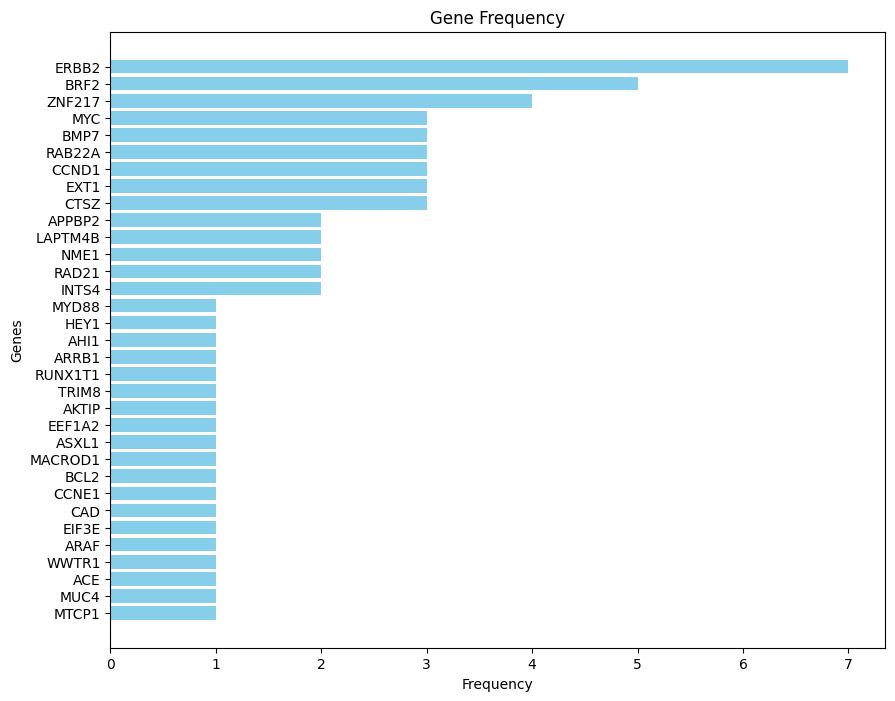

In [109]:
def filter_genes_by_correlation(count_genes, correlation_matrix, top_genes, threshold=0.85):
    # Create a copy of the dictionary to avoid modifying the original
    filtered_genes = count_genes.copy()
    
    # List of genes to be checked
    genes = list(count_genes.keys())
    
    # Compare each gene with every other gene
    for i in range(len(genes)):
        for j in range(i + 1, len(genes)):
            gene1 = genes[i]
            gene2 = genes[j]
            
            # Check if both genes are in top_genes
            if gene1 in top_genes and gene2 in top_genes:
                correlation = correlation_matrix[top_genes.index(gene1), top_genes.index(gene2)]
                
                # If they are highly positively correlated
                if correlation > threshold:
                    # Remove the gene with the lower frequency
                    if count_genes[gene1] < count_genes[gene2]:
                        if gene1 in filtered_genes:
                            del filtered_genes[gene1]
                    else:
                        if gene2 in filtered_genes:
                            del filtered_genes[gene2]
    
    return filtered_genes

filtered_genes = filter_genes_by_correlation(count_genes, correlation_matrix, top_genes)

# Now you can plot the filtered genes
import matplotlib.pyplot as plt

# Sort the dictionary by frequency values in descending order
sorted_filtered_genes = dict(sorted(filtered_genes.items(), key=lambda item: item[1], reverse=True))

# Extract keys and values for plotting
genes = list(sorted_filtered_genes.keys())
frequencies = list(sorted_filtered_genes.values())
for gene in genes:
    print(gene)
# Plotting
plt.figure(figsize=(10, 8))
plt.barh(genes, frequencies, color='skyblue')
plt.xlabel('Frequency')
plt.ylabel('Genes')
plt.title('Gene Frequency')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest frequency on top
plt.show()


Annotating
==

`Non-filtered`
===

Correlation Matrix
===

In [22]:
# create correlation matrix between top 15 oncogenes and top 50 genes:
aggData = pd.read_csv('./data/aggregated_results.csv')
aggData = aggData[['Sample name', 'Classification', "Location",'Oncogenes', 'All genes']]

brCan = aggData[aggData['Sample name'].str.contains('BREAST')].dropna(subset=['Classification'])
brecdna = brCan[brCan['Classification'].str.contains('ecDNA')]
brCanNonEc = brCan[((brCan.Classification != 'ecDNA'))]
def obtain_frequencies(brCan, column):
    dict = {}
    for c in brCan[column]:
        c = c[1:len(c) - 1]
        x = list(c.split(", "))
    
        for g in x:
            g = g[1:len(g) - 1]
            if g == '':
                continue
            if g not in dict:
                dict[g] = 1
            else:
                dict[g] += 1
    
    sortDict = sorted(dict.items(), key=lambda x: x[1], reverse = True)
    return sortDict
freq_ecdna = obtain_frequencies(brecdna, "Oncogenes")
p_ecdna = pd.DataFrame(freq_ecdna, columns = ["gene", "frequency"])

# top 15 oncogenes
top_oncogenes =list(np.array(p_ecdna["gene"]))[0:20]

# top 100 genes 
freq_ecdna = obtain_frequencies(brecdna, "All genes")
p_ecdna = pd.DataFrame(freq_ecdna, columns = ["gene", "frequency"])
top_genes = list(np.array(p_ecdna["gene"]))[0:20]

In [23]:
adjacency_matrix = np.zeros((len(top_oncogenes), len(top_genes)), dtype=int)
for i, row in brecdna.iterrows():
    oncogenes = ast.literal_eval(row["Oncogenes"])
    genes = ast.literal_eval(row["All genes"])
    for oncogene in oncogenes:
        if oncogene in top_oncogenes:
            for gene in genes:
                if gene in top_genes:
                    oncogene_index = top_oncogenes.index(oncogene)
                    gene_index = top_genes.index(gene)
                    adjacency_matrix[oncogene_index][gene_index] += 1
print(adjacency_matrix.shape)
normalized_adjacency_matrix = adjacency_matrix / adjacency_matrix.sum(axis=0)
print(normalized_adjacency_matrix.shape)

(20, 20)
(20, 20)


(20, 20)
20


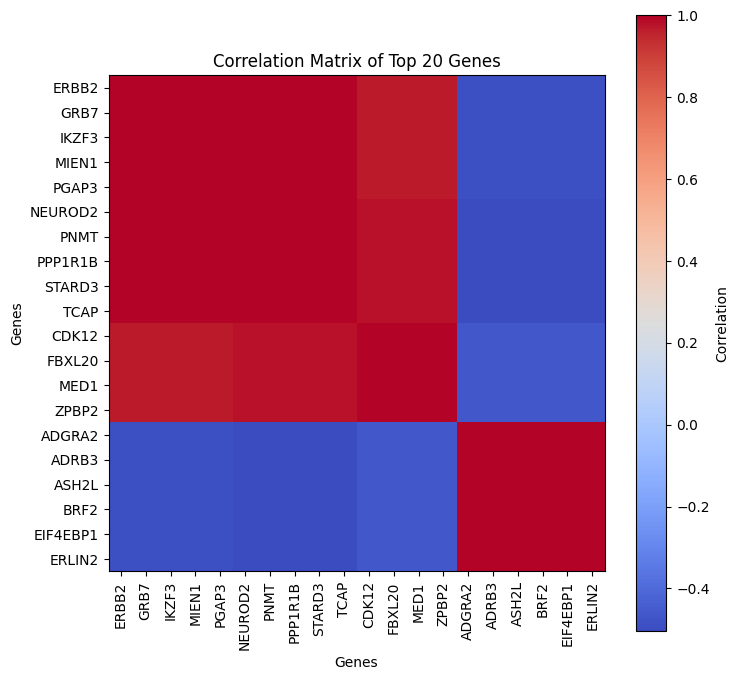

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# Step 3: Compute the correlation matrix
correlation_matrix = np.corrcoef(normalized_adjacency_matrix.T)
print(correlation_matrix.shape)
print(len(correlation_matrix))

# Step 4: Create a heatmap of the correlation matrix
plt.figure(figsize=(8, 8))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar(label='Correlation')
plt.title('Correlation Matrix of Top 20 Genes')
plt.xticks(np.arange(len(top_genes)), top_genes, rotation=90)
plt.yticks(np.arange(len(top_genes)), top_genes)
plt.xlabel('Genes')
plt.ylabel('Genes')
plt.show()



# 

In [23]:
output = "./possible_locations.bed"
with open(output, "w") as file:
    for key in filtered_dict:
        for item in filtered_dict[key]:
            file.write(f"{key}:{item[0]}-{item[1]}\n")
            print(f"{key}:{item[0]}-{item[1]}")
            
        

chr6:134041114-135671127
chr9:1130056-18580931
chr9:30201514-30831545
chrX:10163285-48353595
chrX:51278963-58100000
chrX:145475605-156025894
chr11:66275518-71395645
chr11:72980412-80549296
chr11:94332724-95257699
chr10:35524914-35914913
chr10:69180392-82680407
chr15:23706861-25666803
chr3:37936027-38301037
chr3:121720569-122000569
chr3:148940566-150655565
chr3:156675564-156880564
chr3:195690559-197295559
chr7:114216157-115016148
chr5:22355606-22550608
chr20:31787076-32597128
chr20:41102674-42132740
chr20:44402886-45292943
chr20:46948050-64289164
chr8:34803918-43200000
chr8:69453423-131503770
chr22:25829320-27294270
chr21:38112183-38172186
chr1:40794685-41114692
chr1:108701169-119856412
chr1:202174108-208184059
chr1:236532607-236662594
chr18:58579346-63799090
chr12:18334686-20199655
chr12:31849456-33200000
chr12:40000253-46475257
chr12:91600284-92030284
chr4:180017986-180317990
chr13:29873084-32023080
chr13:48318049-51388044
chr13:69388010-70153009
chr13:72468004-79992990
chr13:90218115

In [18]:
filtered_dict

{'chr6': [(134041114, 135671127)],
 'chr9': [(1130056, 18580931), (30201514, 30831545)],
 'chrX': [(10163285, 48353595), (51278963, 58100000), (145475605, 156025894)],
 'chr11': [(66275518, 71395645), (72980412, 80549296), (94332724, 95257699)],
 'chr10': [(35524914, 35914913), (69180392, 82680407)],
 'chr15': [(23706861, 25666803)],
 'chr3': [(37936027, 38301037),
  (121720569, 122000569),
  (148940566, 150655565),
  (156675564, 156880564),
  (195690559, 197295559)],
 'chr7': [(114216157, 115016148)],
 'chr5': [(22355606, 22550608)],
 'chr20': [(31787076, 32597128),
  (41102674, 42132740),
  (44402886, 45292943),
  (46948050, 64289164)],
 'chr8': [(34803918, 43200000), (69453423, 131503770)],
 'chr22': [(25829320, 27294270)],
 'chr21': [(38112183, 38172186)],
 'chr1': [(40794685, 41114692),
  (108701169, 119856412),
  (202174108, 208184059),
  (236532607, 236662594)],
 'chr18': [(58579346, 63799090)],
 'chr12': [(18334686, 20199655),
  (31849456, 33200000),
  (40000253, 46475257),
  (

In [27]:
import pandas as pd

data = """
ch2
CAD   chr2:27,217,369-27,243,943
ch3
MYD88    chr3:38,138,661-38,143,022
WWTR1   chr3:149,517,235-149,658,025
MUC4      chr3:195,746,771-195,811,929
chr 6
AHI1      chr6:135,283,532-135,497,740
chr 8
BRF2     chr8:37,843,268-37,849,861
HEY1       chr8:79,764,010-79,767,767
RUNX1T1   chr8:91,954,972-92,103,385
LAPTM4B   chr8:97,775,788-97,853,013
EIF3E      chr8:108,201,216-108,248,717
RAD21   chr8:116,845,934-116,874,776
EXT1     chr8:117,794,490-118,111,826
MYC     chr8:127,736,231-127,742,951
chr 10
TRIM8   chr10:102,644,479-102,658,318
chr 11
MACROD1  chr11:63,998,558-64,166,113
CCND1  chr11:69,641,156-69,654,474
ARRB1   chr11:75,260,122-75,351,661
INTS4    chr11:77,878,720-77,994,668
chr 16
AKTIP    chr16:53,491,040-53,503,209
chr 17
ERBB2    chr17:39,700,064-39,728,658
NME1    chr17:51,153,559-51,162,168
APPBP2  chr17:60,443,158-60,526,242
ACE        chr17:63,477,061-63,498,373
chr 18
BCL2    chr18:63,123,346-63,319,769
chr 19
CCNE1  chr19:29,811,991-29,824,312
chr 20
ASXL1       chr20:32,358,331-32,439,319
ZNF217    chr20:53,567,071-53,593,839
BMP7       chr20:57,168,753-57,266,641
RAB22A    chr20:58,309,715-58,367,507
CTSZ         chr20:58,995,185-59,007,254
EEF1A2     chr20:63,488,014-63,499,083
chr X
ARAF    chrX:47,561,205-47,571,908
MTCP1  chrX:155,064,034-155,071,136
"""

lines = data.split('\n')

genes = []
locations = []

for line in lines:
    if line.startswith('chr') or line.startswith('ch'):
        continue
    parts = line.split()
    if len(parts) == 2:
        gene, location = parts
        genes.append(gene)
        locations.append(location)

df = pd.DataFrame({'Gene Name': genes, 'Location': locations})
print(df)

df

   Gene Name                       Location
0        CAD     chr2:27,217,369-27,243,943
1      MYD88     chr3:38,138,661-38,143,022
2      WWTR1   chr3:149,517,235-149,658,025
3       MUC4   chr3:195,746,771-195,811,929
4       AHI1   chr6:135,283,532-135,497,740
5       BRF2     chr8:37,843,268-37,849,861
6       HEY1     chr8:79,764,010-79,767,767
7    RUNX1T1     chr8:91,954,972-92,103,385
8    LAPTM4B     chr8:97,775,788-97,853,013
9      EIF3E   chr8:108,201,216-108,248,717
10     RAD21   chr8:116,845,934-116,874,776
11      EXT1   chr8:117,794,490-118,111,826
12       MYC   chr8:127,736,231-127,742,951
13     TRIM8  chr10:102,644,479-102,658,318
14   MACROD1    chr11:63,998,558-64,166,113
15     CCND1    chr11:69,641,156-69,654,474
16     ARRB1    chr11:75,260,122-75,351,661
17     INTS4    chr11:77,878,720-77,994,668
18     AKTIP    chr16:53,491,040-53,503,209
19     ERBB2    chr17:39,700,064-39,728,658
20      NME1    chr17:51,153,559-51,162,168
21    APPBP2    chr17:60,443,158

,Gene Name,Location
0,CAD,"chr2:27,217,369-27,243,943"
1,MYD88,"chr3:38,138,661-38,143,022"
2,WWTR1,"chr3:149,517,235-149,658,025"
3,MUC4,"chr3:195,746,771-195,811,929"
4,AHI1,"chr6:135,283,532-135,497,740"
5,BRF2,"chr8:37,843,268-37,849,861"
6,HEY1,"chr8:79,764,010-79,767,767"
7,RUNX1T1,"chr8:91,954,972-92,103,385"
8,LAPTM4B,"chr8:97,775,788-97,853,013"
9,EIF3E,"chr8:108,201,216-108,248,717"
